In [23]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import datetime
import queue
import contextlib
import time
import PyQt5
from scipy.stats import skewnorm, pareto
from datetime import date

In [2]:
# pip install PyQt5

#### Import the logs (backlog + incoming) from .CSV and create DataFrame

In [62]:
# log_df = pl.read_csv('defectRemediation_log_simulation_vPrototype_v2.csv')
# log_df = log_df.with_columns(pl.col('Timestamp').str.strptime(pl.Datetime, '%Y-%d-%m %H:%M:%S'))
# log_df = log_df.with_columns(pl.col("Timestamp").dt.date().alias("Date"))
# log_df = log_df.with_columns(pl.col("Timestamp").dt.hour().alias("Hour"))
# log_df

log_df = pd.read_csv('defectRemediation_log_simulation_vPrototype_v2.csv', index_col='ID')
log_df['Timestamp'] = pd.to_datetime(log_df['Timestamp'], format='%Y-%d-%m %H:%M:%S')
log_df
# incoming_log_df = pl.read_csv('defectRemediation_log_incoming_simulation_vPrototype.csv')
# incoming_log_df['Timestamp'] = pl.to_datetime(incoming_log_df['Timestamp'], format='%Y-%d-%m %H:%M:%S')
# incoming_log_df

,Defect_ID,Control_Type,State,Timestamp
ID,,,,
1,1,ACC03,new,2025-05-16 00:05:31
2,2,ACC17,new,2025-05-16 00:12:42
3,3,ACC28,new,2025-05-16 00:13:44
4,1,ACC03,assign,2025-05-16 00:18:57
5,1,ACC03,in-progress,2025-05-16 00:22:43
...,...,...,...,...
112,29,ACC17,in-progress,2025-05-29 12:05:29
113,27,ACC17,in-progress,2025-05-29 13:47:03
114,29,ACC17,closed,2025-05-30 09:58:24


In [63]:
for row in log_df.iterrows():
    ## Add new columns 'Date' and 'Hour' for tracking incoming defects per hour
    log_df.loc[row[0], 'Date'] = log_df.loc[row[0], 'Timestamp'].date()
    log_df.loc[row[0], 'Hour'] = log_df.loc[row[0], 'Timestamp'].hour
log_df

,Defect_ID,Control_Type,State,Timestamp,Date,Hour
ID,,,,,,
1,1,ACC03,new,2025-05-16 00:05:31,2025-05-16,0.0
2,2,ACC17,new,2025-05-16 00:12:42,2025-05-16,0.0
3,3,ACC28,new,2025-05-16 00:13:44,2025-05-16,0.0
4,1,ACC03,assign,2025-05-16 00:18:57,2025-05-16,0.0
5,1,ACC03,in-progress,2025-05-16 00:22:43,2025-05-16,0.0
...,...,...,...,...,...,...
112,29,ACC17,in-progress,2025-05-29 12:05:29,2025-05-29,12.0
113,27,ACC17,in-progress,2025-05-29 13:47:03,2025-05-29,13.0
114,29,ACC17,closed,2025-05-30 09:58:24,2025-05-30,9.0


#### Fill in delta table based on log entries in snapshot

In [65]:
class logEntry:
    def __init__(self, row_id, sub_log_df):
        self.defect_id = sub_log_df.loc[row_id, 'Defect_ID']
        self.state = sub_log_df.loc[row_id, 'State']
        self.control_type = sub_log_df.loc[row_id, 'Control_Type']
        self.sub_log_df = sub_log_df

    def checkState(self, index, deltas_df, empirical_dict):
        if self.state == 'new':
            ## append to delta table with defect_ID and control_type
            deltas_df.loc[index, ['Defect_ID', 'Control_Type']] = [self.defect_id, self.control_type]
            index += 1

        if self.state =='assign':
            delta_new_assign, empirical_dict = self.stateAssign(empirical_dict)
            deltas_df.loc[deltas_df['Defect_ID'] == self.defect_id, 'Delta_New_Assign'] = delta_new_assign
    
            # log_entry.updateDeltaTable(delta_new_assign, sub_deltas_df)

        elif self.state == 'in-progress':
            delta_assign_inprogress, empirical_dict = self.stateInProgress(empirical_dict)
            deltas_df.loc[deltas_df['Defect_ID'] == self.defect_id, 'Delta_Assign_InProgress'] = delta_assign_inprogress
        
        elif self.state == 'closed':
            delta_inprogress_closed, delta_new_closed, empirical_dict = self.stateClosed(empirical_dict)
            deltas_df.loc[deltas_df['Defect_ID'] == self.defect_id, ['Delta_InProgress_Closed', 'Delta_New_Closed']] = [delta_inprogress_closed, delta_new_closed]
        
        return index, deltas_df, empirical_dict

# def stateNew(self):
## create new delta table row

    def stateAssign(self, empirical_dict):
        timestamp_new = self.sub_log_df.loc[(self.sub_log_df['Defect_ID']==self.defect_id) & (self.sub_log_df['State']=='new')]['Timestamp'].iloc[0]
        timestamp_assign = self.sub_log_df.loc[(self.sub_log_df['Defect_ID']==self.defect_id) & (self.sub_log_df['State']==self.state)]['Timestamp'].iloc[0]
        
        ## time between assign and new (hrs)
        delta_new_assign = self.computeDelta(timestamp_new, timestamp_assign)
        
        ## append value to empirical dict
        empirical_dict[self.control_type]['delta_new_assign'].append(delta_new_assign)
        return delta_new_assign, empirical_dict
    
    def stateInProgress(self, empirical_dict):
        timestamp_assign = self.sub_log_df.loc[(self.sub_log_df['Defect_ID']==self.defect_id) & (self.sub_log_df['State']=='assign')]['Timestamp'].iloc[0]
        timestamp_inprogress = self.sub_log_df.loc[(self.sub_log_df['Defect_ID']==self.defect_id) & (self.sub_log_df['State']==self.state)]['Timestamp'].iloc[0]
        
        ## time between in-progress and assign (hrs)
        delta_assign_inprogress = self.computeDelta(timestamp_assign, timestamp_inprogress)
        
        ## append value to empirical dict
        empirical_dict[self.control_type]['delta_assign_inprogress'].append(delta_assign_inprogress)
        return delta_assign_inprogress, empirical_dict
    
    def stateClosed(self, empirical_dict):
        timestamp_new = self.sub_log_df.loc[(self.sub_log_df['Defect_ID']==self.defect_id) & (self.sub_log_df['State']=='new')]['Timestamp'].iloc[0]
        timestamp_inprogress = self.sub_log_df.loc[(self.sub_log_df['Defect_ID']==self.defect_id) & (self.sub_log_df['State']=='in-progress')]['Timestamp'].iloc[0]
        timestamp_closed = self.sub_log_df.loc[(self.sub_log_df['Defect_ID']==self.defect_id) & (self.sub_log_df['State']==self.state)]['Timestamp'].iloc[0]
        
        ## time between closed and in-progress, and closed and new (hrs)
        delta_inprogress_closed = self.computeDelta(timestamp_inprogress, timestamp_closed)
        delta_new_closed = self.computeDelta(timestamp_new, timestamp_closed)
        
        ## append value to empirical dict
        empirical_dict[self.control_type]['delta_inprogress_closed'].append(delta_inprogress_closed)
        empirical_dict[self.control_type]['delta_new_closed'].append(delta_new_closed)
        return delta_inprogress_closed, delta_new_closed, empirical_dict
    
     # def updateDeltaTable(self, delta_state_state):
    def computeDelta(self, timestamp_older, timestamp_newer):
        ## Computes the time delta (in hrs) as timestamp_newer - timestamp_older
        delta_timestamps = timestamp_newer - timestamp_older
        delta_timestamps = round(delta_timestamps.total_seconds()/3600, 3)
        return delta_timestamps

#### Update histograms each snapshot

In [66]:
class buildHistories:
    def __init__(self, control_type, sub_log_df, sub_deltas_df, incoming_dict, outgoing_dict, empirical_dict):
        self.control_type = control_type
        
        ## only need state == 'new' for incoming defects per hour histograms, state == 'closed' for outgoing defects per hour histograms
        self.sub_log_df2_inc = sub_log_df.query('State == "new"')
        self.sub_log_df2_out = sub_log_df.query('State == "closed"')

        self.sub_deltas_df = sub_deltas_df
        self.incoming_dict = incoming_dict
        self.outgoing_dict = outgoing_dict
        self.empirical_dict = empirical_dict

    def updateFigures(self):
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
        axs[0].plot(range(1,len(self.sub_deltas_df['Delta_New_Assign'])+1), self.sub_deltas_df['Delta_New_Assign'], 'k-o', markersize=6)
        axs[0].set_ylabel('time (hrs)')
        axs[0].set_title('Delta_New_Assign', loc='left', fontsize=10)

        axs[1].plot(range(1,len(self.sub_deltas_df['Delta_Assign_InProgress'])+1), self.sub_deltas_df['Delta_Assign_InProgress'], 'k-o', markersize=6)
        axs[1].set_title('Delta_Assign_InProgress', loc='left', fontsize=10)

        axs[2].plot(range(1,len(self.sub_deltas_df['Delta_InProgress_Closed'])+1), self.sub_deltas_df['Delta_InProgress_Closed'], 'k-o', markersize=6)
        axs[2].set_title('Delta_InProgress_Closed', loc='left', fontsize=10)

        axs[3].plot(range(1,len(self.sub_deltas_df['Delta_New_Closed'])+1), self.sub_deltas_df['Delta_New_Closed'], 'k-o', markersize=6)
        axs[3].set_title('Delta_New_Closed', loc='left', fontsize=10)
    
        fig.text(0.5, 0.95, f'{self.control_type}', ha='center', fontsize=12)
        plt.savefig(f'{self.control_type}_fig_{date.today()}.png', bbox_inches='tight')
        plt.close()

    # def deltaDistributions(self):

    def updateIncoming(self):
        for day in self.sub_log_df2_inc["Date"].unique(): # TO DO - how to track date outside of logs (i.e. if no state changes/defects generated, dates do not appear in logs 
            sub_log_df2_inc_date = self.sub_log_df2_inc.query('Date == @day')['Hour'].value_counts()
            incoming_defects = [sub_log_df2_inc_date.loc[i] if i in sub_log_df2_inc_date.index else 0 for i in range(0,24)]
            self.incoming_dict[control_type].update({day: incoming_defects})
            self.empirical_dict[control_type]['incoming_per_hour'] = self.empirical_dict[control_type]['incoming_per_hour'] + self.incoming_dict[control_type][day]
        return self.incoming_dict, self.empirical_dict
    
    def updateOutgoing(self):
        for day in self.sub_log_df2_out["Date"].unique(): # will never be empty 
            sub_log_df2_out_date = self.sub_log_df2_out.query('Date == @day')['Hour'].value_counts()
            outgoing_defects = [sub_log_df2_out_date.loc[i] if i in sub_log_df2_out_date.index else 0 for i in range(0,24)]
            self.outgoing_dict[control_type].update({day: outgoing_defects})
            self.empirical_dict[control_type]['outgoing_per_hour'] = self.empirical_dict[control_type]['outgoing_per_hour'] + self.outgoing_dict[control_type][day]
        return self.outgoing_dict, self.empirical_dict

#### Answer questions about the snapshot

In [67]:
class answeringQuestions:
    def __init__(self):
        pass

    def generated_per_hour(self):
        pass
    def remediated_per_hour(self):
        pass
    def total_remediation_time(self):
        pass
    def waiting_in_backlog_time(self):
        pass
    def state_changes_tracking(self):
        pass
    

#### 1 class per control type

In [68]:
class ACC03:
    def __init__(self, sub_log_df_ACC03):
        self.control_type = 'ACC03'
        self.sub_log_df = sub_log_df_ACC03

    def updateDeltaTable(self, index, deltas_df, empirical_dict):
        processing_queue_ACC03 = queue.Queue()
        for row in self.sub_log_df.iterrows():
            # self.sub_log_df.loc[row[0], 'Date'] = self.sub_log_df.loc[row[0], 'Timestamp'].date()
            # self.sub_log_df.loc[row[0], 'Hour'] = self.sub_log_df.loc[row[0], 'Timestamp'].hour
            with contextlib.suppress(IndexError):
                processing_queue_ACC03.put(row[0], block=False)

        while processing_queue_ACC03.qsize() > 0: # takes previous 24h of data
            # for _ in range(processing_queue.qsize()):
            with contextlib.suppress(queue.Empty):
                row_id = processing_queue_ACC03.get(block=False)
            
            log_entry = logEntry(row_id, self.sub_log_df)
            index, deltas_df, empirical_dict = log_entry.checkState(index, deltas_df, empirical_dict)
        return index, deltas_df, empirical_dict

    def updateHistograms(self, deltas_df, incoming_dict, outgoing_dict, empirical_dict):
        sub_deltas_df = deltas_df.query('Control_Type == @self.control_type').dropna()
        histories = buildHistories(self.control_type, self.sub_log_df, sub_deltas_df, incoming_dict, outgoing_dict, empirical_dict)
        if sub_deltas_df.empty == 0:
            histories.updateFigures() ## update the figure for this control type
            incoming_dict, empirical_dict = histories.updateIncoming() ## update incoming defect distributions for this control_type
            # histories.updateIncoming() ## update incoming defect distributions for this control_type
            outgoing_dict, empirical_dict = histories.updateOutgoing() ## update outgoing defect distributions for this control_type
        return incoming_dict, outgoing_dict, empirical_dict

    def answerQuestions(self):
        pass

## Run simulation

In [69]:
# master dictionary with tracked empirical data to build distributions
empirical_dict = {}
incoming_dict = {}
outgoing_dict = {}
control_types = log_df['Control_Type'].unique()
for control_type in control_types:
    empirical_dict[control_type] = {'incoming_per_hour': [],
                                    'outgoing_per_hour': [],
                                    'delta_new_assign': [],
                                    'delta_assign_inprogress': [],
                                    'delta_inprogress_closed': [],
                                    'delta_new_closed': []
                                   }
    incoming_dict[control_type] = {}
    outgoing_dict[control_type] = {}

# initializing empty delta table
deltas_df = pd.DataFrame(columns=['Defect_ID','Control_Type','Delta_New_Assign','Delta_Assign_InProgress','Delta_InProgress_Closed', 'Delta_New_Closed'])

In [72]:
deltas_df

,Defect_ID,Control_Type,Delta_New_Assign,Delta_Assign_InProgress,Delta_InProgress_Closed,Delta_New_Closed
0,1,ACC03,0.224,0.063,0.204,0.49
1,5,ACC03,0.845,0.466,0.731,2.041
2,8,ACC03,0.329,0.206,2.983,3.518
3,9,ACC03,0.271,3.382,4.347,8.0
4,10,ACC03,1.506,2.044,2.186,5.736
5,11,ACC03,16.184,3.04,4.576,23.8
6,12,ACC03,15.869,0.028,3.781,19.678
7,13,ACC03,17.233,1.986,4.589,23.809
8,14,ACC03,18.747,1.334,3.745,23.826
9,19,ACC03,24.622,45.928,8.219,78.768


In [71]:
try: ## deltas_df contains some entries, add onto it
    Last_ID_processed = deltas_df.index[-1]
    index = Last_ID_processed + 1
except IndexError: ## deltas_df is empty, start from beginning
    index = 0 

# for control_type in control_types:
control_type = "ACC03" 
sub_log_df = log_df.query('Control_Type == @control_type')
exec("instance = " + control_type + "(sub_log_df)")
index, deltas_df, empirical_dict = instance.updateDeltaTable(index, deltas_df, empirical_dict)
incoming_dict, outgoing_dict, empirical_dict = instance.updateHistograms(deltas_df, incoming_dict, outgoing_dict, empirical_dict)
    

In [8]:
# defect_type = 'ACC03'
# myString = "test_run = " + defect_type + "()"
# myString
# exec(myString)

In [8]:
# appending entries of previous 24h to the processing queue
processing_queue = queue.Queue()
for row in log_df.iterrows():
    with contextlib.suppress(IndexError):
        processing_queue.put(row[0], block=False)

processing_queue.qsize()

116

In [9]:
## process entries in previous 24h one at a time
while processing_queue.qsize() > 0: # takes previous 24h of data
# for _ in range(processing_queue.qsize()):
    with contextlib.suppress(queue.Empty):
        row_id = processing_queue.get(block=False)
# for row in log_df.iterrows():
    
    ## Add new columns 'Date' and 'Hour' for tracking incoming defects per hour 
    log_df.loc[row_id, 'Date'] = log_df.loc[row_id, 'Timestamp'].date()
    log_df.loc[row_id, 'Hour'] = log_df.loc[row_id, 'Timestamp'].hour

    ## Extract the defect ID, state, and control type of the log entry, and any other entries with the same defect ID (sub_log_df)
    defect_id = log_df.loc[row_id, 'Defect_ID']
    state = log_df.loc[row_id, 'State']
    control_type = log_df.loc[row_id, 'Control_Type']
    # timestamp = log_df.loc[row[0], 'Timestamp']
    sub_log_df = log_df.query('Defect_ID == @defect_id')

    ## Initialize class logEntry
    log_entry = logEntry(defect_id, state, control_type, sub_log_df)

    if state == 'new':
        ## append to delta table with defect_ID and control_type
        try: ## deltas_df contains some entries, add onto it
            Last_ID_processed = deltas_df.index[-1]
            index = Last_ID_processed + 1
        except IndexError: ## deltas_df is empty, start from beginning
            index = 0 
        deltas_df.loc[index, ['Defect_ID', 'Control_Type']] = [defect_id, control_type]
        ####### Should deltas_df be passed to a method and updated in the class?
    
    if state =='assign':
        delta_new_assign, empirical_dict = log_entry.stateAssign(empirical_dict)
        deltas_df.loc[deltas_df['Defect_ID'] == defect_id, 'Delta_New_Assign'] = delta_new_assign
        
        # log_entry.updateDeltaTable(delta_new_assign, sub_deltas_df)
    
    elif state == 'in-progress':
        delta_assign_inprogress, empirical_dict = log_entry.stateInProgress(empirical_dict)
        deltas_df.loc[deltas_df['Defect_ID'] == defect_id, 'Delta_Assign_InProgress'] = delta_assign_inprogress
    
    elif state == 'closed':
        delta_inprogress_closed, delta_new_closed, empirical_dict = log_entry.stateClosed(empirical_dict)
        deltas_df.loc[deltas_df['Defect_ID'] == defect_id, ['Delta_InProgress_Closed', 'Delta_New_Closed']] = [delta_inprogress_closed, delta_new_closed]

In [10]:
## update figures and histograms with last 24h data
for control_type in control_types:
    ## if state == 'closed', all deltas for a given defect have been computed - extract all rows of control_type and keep only those with state == 'closed' 
    sub_deltas_df = deltas_df.query('Control_Type == @control_type').dropna()

    ## only need state == 'new' for incoming defects per hour histograms, state == 'closed' for outgoing defects per hour histograms
    sub_log_df2_inc = log_df.query('(Control_Type == @control_type) and (State == "new")')
    sub_log_df2_out = log_df.query('(Control_Type == @control_type) and (State == "closed")')

    histories = buildHistories(control_type, sub_deltas_df, sub_log_df2_inc, sub_log_df2_out, incoming_dict, outgoing_dict, empirical_dict)
    if sub_deltas_df.empty == 0:
        histories.updateFigures() ## update the figure for this control type
    incoming_dict, empirical_dict = histories.updateIncoming() ## update incoming defect distributions for this control_type
    # histories.updateIncoming() ## update incoming defect distributions for this control_type
    outgoing_dict, empirical_dict = histories.updateOutgoing() ## update outgoing defect distributions for this control_type

In [11]:
deltas_df

,Defect_ID,Control_Type,Delta_New_Assign,Delta_Assign_InProgress,Delta_InProgress_Closed,Delta_New_Closed
0,1,ACC03,0.224,0.063,0.204,0.49
1,2,ACC17,0.501,0.503,0.779,1.783
2,3,ACC28,1.5,1.594,1.067,4.16
3,4,AUTH18,1.039,0.229,1.603,2.871
4,5,ACC03,0.845,0.466,0.731,2.041
5,6,AUTH42,0.378,0.029,0.092,0.499
6,7,ACC17,1.597,0.052,0.047,1.696
7,8,ACC03,0.329,0.206,2.983,3.518
8,9,ACC03,0.271,3.382,4.347,8.0
9,10,ACC03,1.506,2.044,2.186,5.736


In [12]:
empirical_dict

{'ACC03': {'incoming_per_hour': [1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   2,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   4,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'outgoing_per_hour': [1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   2,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,


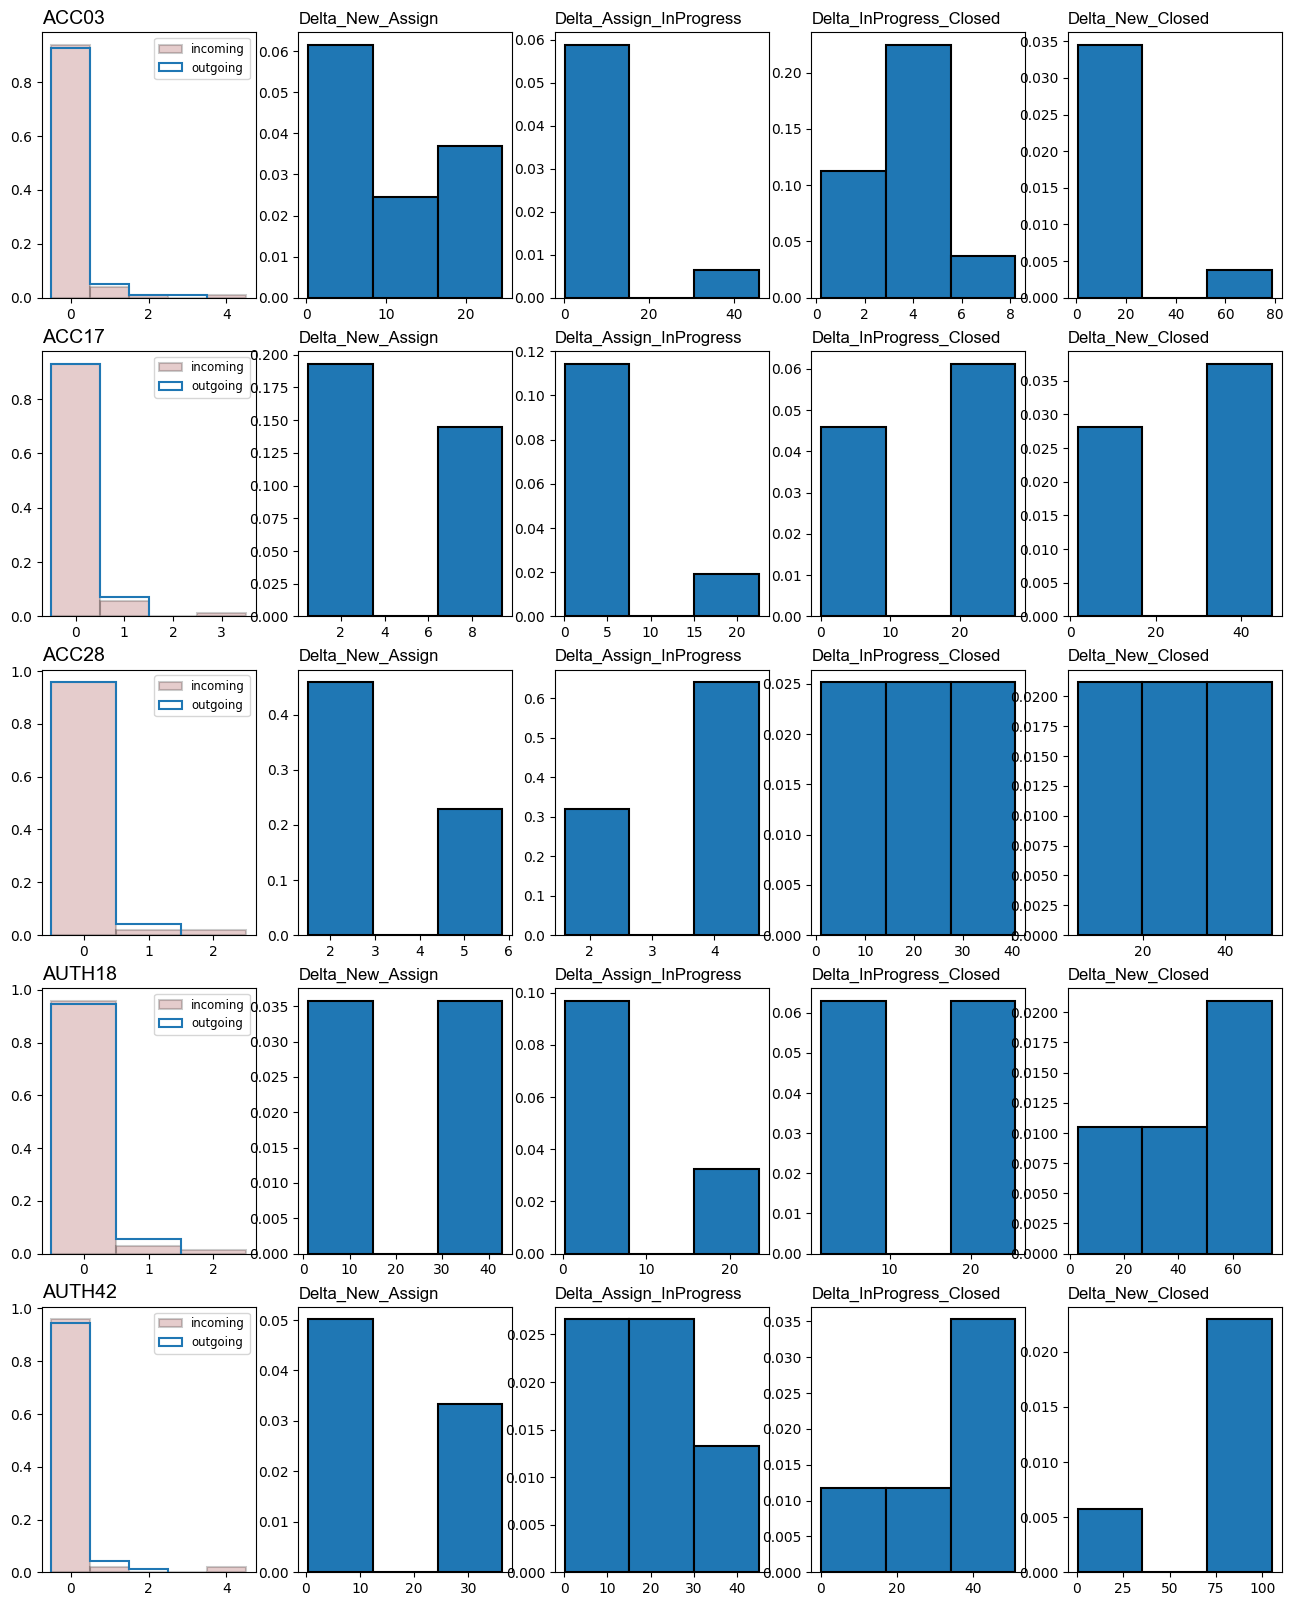

In [19]:
csfont = {'fontname':'Arial'}
fig, axs = plt.subplots (len(empirical_dict.keys()), 5, figsize=(16,20))
for index, value in enumerate(empirical_dict.keys()):
    # incoming_per_hour histogram
    data_incoming = np.array(empirical_dict[value]['incoming_per_hour'])
    unique_values = np.unique(data_incoming)
    if np.all(unique_values) == 0:
        d = 1
    else:
        d = np.diff(unique_values).min()
    left_of_first_bin = data_incoming.min() - float(d)/2
    right_of_last_bin = data_incoming.max() + float(d)/2
    axs[index][0].hist(data_incoming, np.arange(left_of_first_bin, right_of_last_bin + d, d), label='incoming', color='maroon', alpha=0.2, edgecolor='black', linewidth=1.5, density=True)
    axs[index][0].set_title(f'{value}', loc='left', fontsize=14, **csfont)

    # outgoing_per_hour histogram 
    data_outgoing = np.array(empirical_dict[value]['outgoing_per_hour'])
    unique_values = np.unique(data_outgoing)
    if np.all(unique_values) == 0:
        d = 1
    else:
        d = np.diff(unique_values).min()
    left_of_first_bin = data_outgoing.min() - float(d)/2
    right_of_last_bin = data_outgoing.max() + float(d)/2
    axs[index][0].hist(data_outgoing, np.arange(left_of_first_bin, right_of_last_bin + d, d), label='outgoing', histtype='step', linewidth=1.5, density=True)
    # axs[index][0].set_title(f'{value}', loc='left', fontsize=14, **csfont)
    axs[index][0].legend(fontsize='small')

    # delta histograms
    axs[index][1].hist(empirical_dict[value]['delta_new_assign'], bins=3, edgecolor='black', linewidth=1.5, density=True)
    axs[index][2].hist(empirical_dict[value]['delta_assign_inprogress'], bins=3, edgecolor='black', linewidth=1.5, density=True)
    axs[index][3].hist(empirical_dict[value]['delta_inprogress_closed'], bins=3, edgecolor='black', linewidth=1.5, density=True)
    axs[index][4].hist(empirical_dict[value]['delta_new_closed'], bins=3, edgecolor='black', linewidth=1.5, density=True)

    axs[index][1].set_title('Delta_New_Assign', loc='left', fontsize=12, **csfont)
    axs[index][2].set_title('Delta_Assign_InProgress', loc='left', fontsize=12, **csfont)
    axs[index][3].set_title('Delta_InProgress_Closed', loc='left', fontsize=12, **csfont)
    axs[index][4].set_title('Delta_New_Closed', loc='left', fontsize=12, **csfont)


plt.show()

### Candlestick from histogram

In [182]:
# build artifical histograms (temporary)
# ACC03
snapshots = {'snapshot1': [],
             'snapshot2': [],
             'snapshot3': [],
             'snapshot4': [],
             'snapshot5': [],
             'snapshot6': [],
            }
maxValue= 4
# skewness_incoming = 5
pareto_incoming = 10
for key in snapshots.keys(): 
    # samples_incoming = skewnorm.rvs(skewness_incoming, size=1000)
    samples_incoming = pareto.rvs(pareto_incoming, size=20)
    samples_incoming_pos = samples_incoming - min(samples_incoming)              # positive values only   
    samples_incoming_pos = samples_incoming_pos / max(samples_incoming_pos)      # standadize all the values between 0 and 1 
    samples_incoming_pos = np.round(samples_incoming_pos * maxValue)             # spread the standardized values over the range defined by "maxValue" + round to nearest integer
    snapshots[key] = samples_incoming_pos

snapshots['snapshot2'] = np.append(snapshots['snapshot2'], 50)
snapshots['snapshot5'] = np.append(snapshots['snapshot5'], 500)

In [183]:
# snapshots

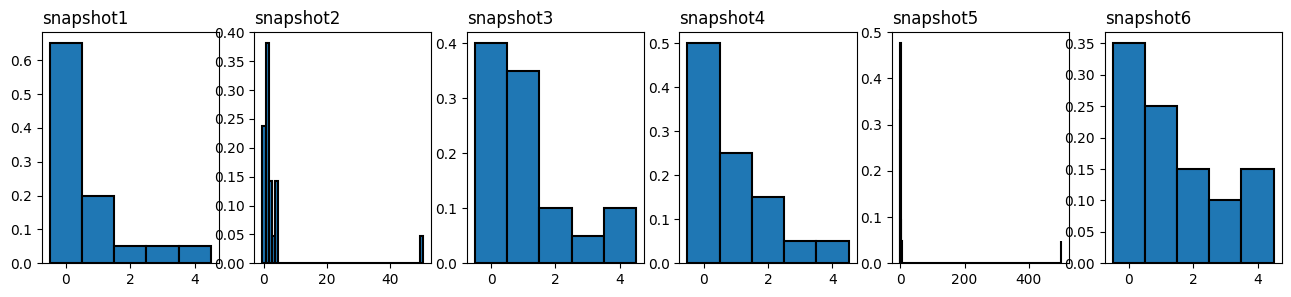

In [184]:
fig, axs = plt.subplots(1, 6, figsize=(16,3))
snapshot_sums = {}
for index, value in enumerate(snapshots.keys()):
    snapshot_sums[value] = sum(snapshots[value])
    data_incoming = snapshots[value]
    unique_values = np.unique(data_incoming)
    if np.all(unique_values) == 0:
        d = 1
    else:
        d = np.diff(unique_values).min()
    left_of_first_bin = data_incoming.min() - float(d)/2
    right_of_last_bin = data_incoming.max() + float(d)/2
    
    axs[index].hist(data_incoming, np.arange(left_of_first_bin, right_of_last_bin + d, d), edgecolor='black', linewidth=1.5, density=True)
    axs[index].set_title(value, loc='left', fontsize=12)
    
plt.show()

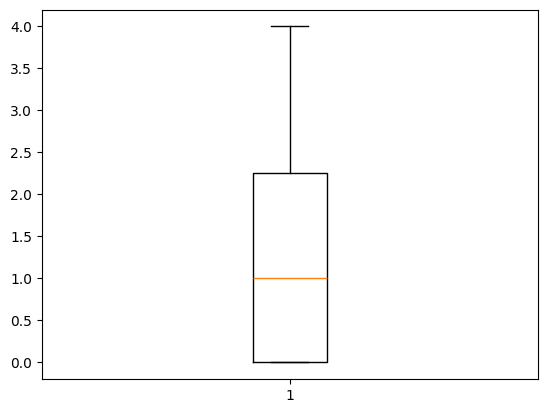

In [185]:
plt.boxplot(data_incoming, whis=(0,100))
plt.show()

#### Total incoming defects per snapshot

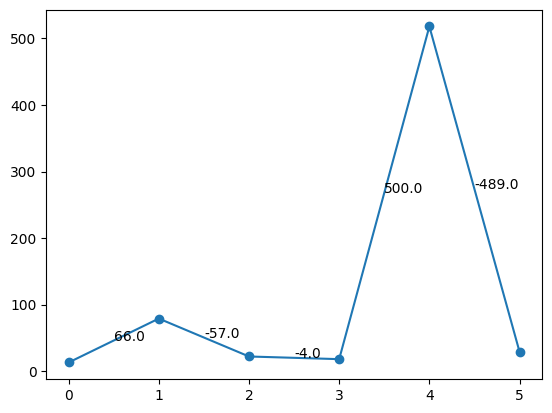

In [217]:
sums = list(snapshot_sums.values())
slopes, midpoints_x, midpoints_y = [], [], []
# slopes = [round(np.polyfit([i+1,i+2], [sums[i],sums[i+1]], 1)[0],1) for i in range(len(sums)-1)]
# midpoints_x = [(2*i+1)/2 for i in range(len(sums)-1)]
# midpoints_y = [(sums[i]+sums[i+1])/2 for i in range(len(sums)-1)]
plt.plot(sums, '-o')
for i in range(len(sums)-1):
    slopes.append(round(np.polyfit([i+1,i+2], [sums[i],sums[i+1]], 1)[0],1))
    midpoints_x.append((2*i+1)/2)
    midpoints_y.append((sums[i]+sums[i+1])/2)
    plt.text(midpoints_x[i], midpoints_y[i], slopes[i])
plt.show()

In [202]:
range(len(sums))

range(0, 6)

In [207]:

# x = [1, 2]
# y = [sums[0], sums[1]]
# slope, intercept = np.polyfit(x, y, 1)
# slope
slopes

[65.99999999999997,
 -56.999999999999936,
 -3.9999999999999956,
 500.0000000000012,
 -489.0000000000014]

#### Stop here ####

In [125]:
current_date = log_df.iloc[0]['Date'] # for computing incoming defects per hour distributions
current_hour = log_df.iloc[0]['Timestamp'].hour # for computing incoming defects per hour distributions 
log_df.query('(Date == @current_date) and (Hour == @current_hour) and (State == "new")')

,Defect_ID,Control_Type,State,Date,Timestamp,Hour
ID,,,,,,
1,1,ACC03,new,2025-16-05,2025-05-16 00:05:31,0.0
2,2,ACC17,new,2025-16-05,2025-05-16 00:12:42,0.0
3,3,ACC28,new,2025-16-05,2025-05-16 00:13:44,0.0


In [ ]:
# update figures method
# update distributions method

In [40]:
sub_deltas_df = deltas_df.query('Control_Type == "ACC03"').dropna()

In [49]:
range(1,len(sub_deltas_df['Delta_New_Assign'])+1)

range(1, 11)

In [48]:
len(sub_deltas_df['Delta_New_Assign'])

10

## Creating Delta table to track time b/w state changes

In [7]:
deltas_df = pd.DataFrame(columns=['Defect_ID','Control_Type','Delta_New_Assign','Delta_Assign_InProgress','Delta_InProgress_Closed', 'Delta_New_Closed'])

In [8]:
try: # deltas_df contains some entries, add onto it
    Last_ID_processed = deltas_df.index[-1]
    index = Last_ID_processed + 1
except IndexError: # deltas_df is empty, start from beginning
    index = 0 

In [9]:
# master dictionary with tracked empirical data to build distributions
empirical_dict = {}
incoming_dict = {}
figure_id_dict = {}
figure_id = 0
control_types = log_df['Control_Type'].unique()
for control_type in control_types:
    empirical_dict[control_type] = {'incoming_per_hour': [],
                                    'delta_new_assign': [],
                                    'delta_assign_inprogress': [],
                                    'delta_inprogress_closed': [],
                                    'delta_new_closed': []
                                   }
    incoming_dict[control_type] = {}
    figure_id_dict[control_type] = figure_id
    figure_id += 1

In [10]:
%matplotlib qt

In [11]:
t_end = 50

In [12]:
# fig, axs = plt.subplots (1, len(empirical_dict.keys()), figsize=(16,20))
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for _ in range(processing_queue.qsize()):
    #### PULL DEFECT TO PROCESS - IN CHRONOLOGICAL ORDER OF STATE == "CLOSED" ####
    # if processing_queue.qsize() > 0:
    with contextlib.suppress(queue.Empty):
        defect_id = processing_queue.get(block=False)
        
    #### Recover timestamps for each state change ####
    timestamp_new = log_df.loc[(log_df['Defect_ID']==defect_id) & (log_df['State']=='new')]['Timestamp'].iloc[0] # OR log_df.query('(Defect_ID == defect_id) and (State == "new")')['Timestamp'].iloc[0]
    timestamp_assign = log_df.loc[(log_df['Defect_ID']==defect_id) & (log_df['State']=='assign')]['Timestamp'].iloc[0]
    timestamp_inprogress = log_df.loc[(log_df['Defect_ID']==defect_id) & (log_df['State']=='in-progress')]['Timestamp'].iloc[0]
    timestamp_closed = log_df.loc[(log_df['Defect_ID']==defect_id) & (log_df['State']=='closed')]['Timestamp'].iloc[0]

    # time between assign and new (hrs)
    delta_new_assign = timestamp_assign - timestamp_new
    delta_new_assign = round(delta_new_assign.total_seconds()/3600, 3)
    
    # time between in-progress and assign (hrs)
    delta_assign_inprogress = timestamp_inprogress - timestamp_assign
    delta_assign_inprogress = round(delta_assign_inprogress.total_seconds()/3600, 3)
    
    # time between closed and in-progress (hrs)
    delta_inprogress_closed = timestamp_closed - timestamp_inprogress
    delta_inprogress_closed = round(delta_inprogress_closed.total_seconds()/3600, 3)

    # time between closed and new (hrs)
    delta_new_closed = sum([delta_new_assign, delta_assign_inprogress, delta_inprogress_closed])

    # append row to df and iterate index
    control_type = log_df.loc[log_df['Defect_ID'] == defect_id].iloc[0]['Control_Type']
    deltas_df.loc[index] = [defect_id, control_type, delta_new_assign, delta_assign_inprogress, delta_inprogress_closed, delta_new_closed]
    # delta_new_closed = deltas_df.loc[index, ['Delta_New_Assign','Delta_Assign_InProgress', 'Delta_InProgress_Closed']].sum()
    # deltas_df.loc[index, 'Delta_New_Closed'] = delta_new_closed
    
    
    #### UPDATE PLOTS ####
    # time.sleep(2)
    # print(i)
    # axs[figure_id_dict[control_type]].plot(delta_new_closed)
    if control_type == "ACC03":
        try:
            last_value = ax[0].lines[-1].get_xdata()[-1]
        except IndexError:
            last_value = 0
        # print(last_value, delta_new_closed)
        ax[0].plot(last_value+1, delta_new_assign, 'ko', markersize=6)
        ax[1].plot(last_value+1, delta_assign_inprogress, 'ko', markersize=6)
        ax[2].plot(last_value+1, delta_inprogress_closed, 'ko', markersize=6)
        ax[3].plot(last_value+1, delta_new_closed, 'ko', markersize=6)
        
    index += 1

ax[0].set_ylabel('time (hrs)')
ax[0].set_title('Delta_New_Assign', loc='left', fontsize=10)
ax[1].set_title('Delta_Assign_InProgress', loc='left', fontsize=10)
ax[2].set_title('Delta_InProgress_Closed', loc='left', fontsize=10)
ax[3].set_title('Delta_New_Closed', loc='left', fontsize=10)
fig.text(0.5, 0.95, 'ACC03', ha='center', fontsize=12)
plt.show()

In [13]:
# ax.lines[-1]

In [14]:
# figure_id_dict

In [15]:
# fig, ax = plt.subplots()
# ax.plot([1, 2, 3],[42, 28, 36])
# try:
#     last_value = plt.gca().lines[0].get_xdata()[-1]
# except IndexError:
#     last_value = 0

# last_value
    


In [ ]:
#### Incoming distributions updated periodically 
# every 20 entries
# 1st update on backlog
# 2nd update on incoming

In [ ]:
## GET CLEAN

In [ ]:
## STAY CLEAN